In [20]:
import pandas as pd

def print_results_table(csv_results_path, methods):
    # Import required libraries
    

    # Load the CSV data (replace with your actual path if reading from file)

    df = pd.read_csv(csv_results_path,sep='\t')
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')

    # filter table so only methods in methods are shown (methods is a tuple)
    mae_table = mae_table[mae_table.columns[mae_table.columns.isin(methods)]]
    # reindex using methods
    mae_table = mae_table.reindex(columns=methods)

    # Function to bold the minimum value in each row
    def highlight_best(s):
        is_min = s == s.min()
        return ['font-weight: bold' if v else '' for v in is_min]

    # Add a row with mean MAE per method
    mae_table.loc['Mean'] = mae_table.mean()

    # Apply the highlighting
    styled = mae_table.style.apply(highlight_best, axis=1).format("{:.5f}")

    # Display the styled table
    return styled






In [42]:
import pandas as pd
import numpy as np

def value_to_cellcolor(val, row_min, row_max, lower_is_better=True, maxtone=50):
    """
    Map a value to a LaTeX \cellcolor command using red!tone / green!tone,
    replicating your color_red2green_01 behavior.
    - val: the value to color
    - row_min, row_max: min/max of the row for normalization
    - lower_is_better: invert if lower values are better
    - maxtone: maximum color intensity (like 50 in your code)
    """
    # normalize 0..1
    norm = (val - row_min) / (row_max - row_min) if row_max > row_min else 0.5
    if lower_is_better:
        norm = 1 - norm
    norm = np.clip(norm, 0, 1)

    # replicate color_red2green_01 logic
    val_scaled = norm * 2 - 1  # scale to [-1,1]
    if val_scaled < 0:
        color = 'red'
        tone = maxtone * (-val_scaled)
    else:
        color = 'green'
        tone = maxtone * val_scaled

    return f"\\cellcolor{{{color}!{int(tone)}}}{val:.5f}"

def export_results_to_latex(csv_results_path, methods, method_names=None):
    # Load the CSV data
    df = pd.read_csv(csv_results_path, sep='\t')
    
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')
    
    # Filter to include only specified methods
    mae_table = mae_table[mae_table.columns[mae_table.columns.isin(methods)]]
    # reindex using methods
    mae_table = mae_table.reindex(columns=methods)

    if method_names is not None:
        # Rename the columns using method_names
        mae_table.columns = method_names
    
    # Add a row with mean MAE per method
    mae_table.loc['Mean'] = mae_table.mean()
    
    # Apply bold formatting to the minimum value in each row
    formatted_rows = []
    for idx, row in mae_table.iterrows():
        min_val = min(row)
        row_min = row.min()
        row_max = row.max()
        is_min = []
        for i, v in enumerate(row):
            if i == 0 and v == min_val:
                # baseline is tied with the minimum → bold only baseline
                is_min.append(True)
            elif v == min_val and row[0] != min_val:
                # baseline is not minimum → bold all other minimums
                is_min.append(True)
            else:
                is_min.append(False)

        formated_row = []
        for v,m in zip(row,is_min):
            if idx != "Mean":
                cell = value_to_cellcolor(v, row_min, row_max, lower_is_better=True, maxtone=50)
            else:
                cell = f"{v:.5f}"
            if m:
                cell = f"\\textbf{{{cell}}}"
            formated_row.append(cell)
        formatted_rows.append(formated_row)
    
    formatted_table = pd.DataFrame(formatted_rows, index=mae_table.index, columns=mae_table.columns)
    formatted_table.index = formatted_table.index.str.replace('_', '\\_', regex=False)

    # Group info
    header_groups = [
        ("Baseline", 1),
        ("E-step mods", 3),
        ("M-step mods", 4)
    ]

    # Build column format (no trailing |)
    column_format = "l"
    for i, (_, count) in enumerate(header_groups):
        column_format += "|" + "c" * count if i > 0 else "c" * count

    # Start LaTeX table
    latex_lines = []
    latex_lines.append(f"\\begin{{tabular}}{{{column_format}}}")
    latex_lines.append("\\toprule")

    # First header row: method groups
    header_line1 = [""]  # Dataset column
    for i, (group_name, count) in enumerate(header_groups):
        group_spec = "c" if i == len(header_groups) - 1 else "c|"
        header_line1.append(f"\\multicolumn{{{count}}}{{{group_spec}}}{{{group_name}}}")
    latex_lines.append(" & ".join(header_line1) + " \\\\")

    # Second header row: method names
    header_line2 = [""] + list(formatted_table.columns)
    latex_lines.append(" & ".join(header_line2) + " \\\\")
    latex_lines.append("\\midrule")

    # Table body
    for idx, row in formatted_table.iterrows():
        if idx == "Mean":
            latex_lines.append("\\hline")
        line = [idx] + list(row)
        latex_lines.append(" & ".join(line) + " \\\\")

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")

    return "\n".join(latex_lines)


## Multiclass results

In [3]:
def get_em_variations(classifier):
    """
    Returns a tuple of EM variations for the given classifier.
    """
    return (
        f'EM_{classifier}',
        f'EM_BCTS_{classifier}',
        f'PSEM_{classifier}',
        f'TSEM_{classifier}',
        f'DEM_{classifier}',
        f'EREM_{classifier}',
        f'DMAPEM_{classifier}',
        f'CSEM_{classifier}',
    )
    

for classifier in ('LR','NN'):
    display(print_results_table('results/ucimulti/allmethods.csv',get_em_variations(classifier)))



Method,EM_LR,EM_BCTS_LR,PSEM_LR,TSEM_LR,DEM_LR,EREM_LR,DMAPEM_LR,CSEM_LR
Dataset,,,,,,,,
abalone,0.07050,0.07462,0.06753,0.05142,0.05395,0.05731,0.05077,0.07050
academic-success,0.03074,0.03184,0.03074,0.03074,0.03074,0.03074,0.04146,0.03074
chess,0.03563,0.03516,0.03441,0.03284,0.02987,0.03563,0.02903,0.03563
cmc,0.09456,0.11260,0.09403,0.09456,0.08970,0.09456,0.10482,0.09456
connect-4,0.03653,0.03489,0.03623,0.03653,0.03323,0.03653,0.03403,0.03653
digits,0.00271,0.00270,0.00271,0.00271,0.00272,0.00271,0.00271,0.00271
dry-bean,0.00425,0.00409,0.00423,0.00425,0.00419,0.00425,0.00425,0.00425
hand_digits,0.00286,0.00295,0.00286,0.00286,0.00285,0.00286,0.00286,0.00286
hcv,0.20780,0.30409,0.20619,0.16657,0.19215,0.16233,0.17029,0.20780


Method,EM_NN,EM_BCTS_NN,PSEM_NN,TSEM_NN,DEM_NN,EREM_NN,DMAPEM_NN,CSEM_NN
Dataset,,,,,,,,
abalone,0.11379,0.09281,0.11290,0.05687,0.10450,0.05814,0.06436,0.11379
academic-success,0.07164,0.17032,0.07164,0.07164,0.07164,0.07164,0.07164,0.07164
chess,0.01620,0.01333,0.01620,0.01719,0.01662,0.01620,0.01649,0.01620
cmc,0.07711,0.09203,0.07694,0.07711,0.07513,0.07711,0.08004,0.07711
connect-4,0.05040,0.02682,0.05040,0.05040,0.05040,0.05040,0.05040,0.05040
digits,0.00223,0.00237,0.00223,0.00224,0.00223,0.00223,0.00223,0.00223
dry-bean,0.00479,0.00457,0.00479,0.00451,0.00479,0.00479,0.00479,0.00479
hand_digits,0.00134,0.00147,0.00134,0.00117,0.00134,0.00134,0.00134,0.00134
hcv,0.24092,0.28035,0.23957,0.16608,0.22775,0.16280,0.18894,0.24092


In [43]:
print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_LR','EM_BCTS_LR','PSEM_LR','TSEM_LR','DMAPEM_LR','DEM_LR','CSEM_LR','EREM_LR'),('EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent')))
print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_NN','EM_BCTS_NN','PSEM_NN','TSEM_NN','DMAPEM_NN','DEM_NN','CSEM_NN','EREM_NN'),('EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent')))

\begin{tabular}{lc|ccc|cccc}
\toprule
 & \multicolumn{1}{c|}{Baseline} & \multicolumn{3}{c|}{E-step mods} & \multicolumn{4}{c}{M-step mods} \\
 & EMQ & Calib & Smooth & Temp & MAP & Damp & Conf & Ent \\
\midrule
abalone & \cellcolor{red!32}0.07050 & \cellcolor{red!50}0.07462 & \cellcolor{red!20}0.06753 & \cellcolor{green!47}0.05142 & \textbf{\cellcolor{green!50}0.05077} & \cellcolor{green!36}0.05395 & \cellcolor{red!32}0.07050 & \cellcolor{green!22}0.05731 \\
academic-success & \textbf{\cellcolor{green!50}0.03074} & \cellcolor{green!39}0.03184 & \cellcolor{green!50}0.03074 & \cellcolor{green!50}0.03074 & \cellcolor{red!50}0.04146 & \cellcolor{green!50}0.03074 & \cellcolor{green!50}0.03074 & \cellcolor{green!50}0.03074 \\
chess & \cellcolor{red!50}0.03563 & \cellcolor{red!42}0.03516 & \cellcolor{red!31}0.03441 & \cellcolor{red!7}0.03284 & \textbf{\cellcolor{green!50}0.02903} & \cellcolor{green!37}0.02987 & \cellcolor{red!50}0.03563 & \cellcolor{red!50}0.03563 \\
cmc & \cellcolor{green!2

/tmp/ipykernel_3984072/790447597.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif v == min_val and row[0] != min_val:
/tmp/ipykernel_3984072/790447597.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif v == min_val and row[0] != min_val:


In [5]:
def get_em_variations(classifier):
    """
    Returns a tuple of EM variations for the given classifier.
    """
    return (
        f'EM_{classifier}',
        f'TSEM_DEM_{classifier}',
        f'TSEM_EREM_{classifier}',
        f'TSEM_DMAPEM_{classifier}',
        f'PSEM_DEM_{classifier}',
        f'PSEM_EREM_{classifier}',
        f'PSEM_DMAPEM_{classifier}',
    )
    

for classifier in ('LR','NN'):
    display(print_results_table('results/ucimulti/allmethods.csv',get_em_variations(classifier)))



Method,EM_LR,TSEM_DEM_LR,TSEM_EREM_LR,TSEM_DMAPEM_LR,PSEM_DEM_LR,PSEM_EREM_LR,PSEM_DMAPEM_LR
Dataset,,,,,,,
abalone,0.07050,0.05142,0.05142,0.05077,0.05367,0.05731,0.05078
academic-success,0.03074,0.03074,0.03074,0.04146,0.03074,0.03074,0.04129
chess,0.03563,0.02987,0.03284,0.02903,0.03065,0.03441,0.02898
cmc,0.09456,0.08970,0.09456,0.10482,0.08956,0.09403,0.10482
connect-4,0.03653,0.03323,0.03653,0.03403,0.03466,0.03623,0.03403
digits,0.00271,0.00272,0.00271,0.00271,0.00272,0.00271,0.00271
dry-bean,0.00425,0.00419,0.00425,0.00425,0.00419,0.00423,0.00423
hand_digits,0.00286,0.00285,0.00286,0.00286,0.00285,0.00286,0.00286
hcv,0.20780,0.19215,0.16657,0.17029,0.19090,0.16233,0.17029


Method,EM_NN,TSEM_DEM_NN,TSEM_EREM_NN,TSEM_DMAPEM_NN,PSEM_DEM_NN,PSEM_EREM_NN,PSEM_DMAPEM_NN
Dataset,,,,,,,
abalone,0.11379,0.05681,0.05687,0.05687,0.10382,0.05814,0.06428
academic-success,0.07164,0.07164,0.07164,0.07164,0.07164,0.07164,0.07164
chess,0.01620,0.01662,0.01719,0.01649,0.01664,0.01620,0.01651
cmc,0.07711,0.07513,0.07711,0.08004,0.07512,0.07694,0.08005
connect-4,0.05040,0.05040,0.05040,0.04698,0.05040,0.05040,0.05040
digits,0.00223,0.00224,0.00224,0.00224,0.00223,0.00223,0.00223
dry-bean,0.00479,0.00442,0.00451,0.00451,0.00479,0.00479,0.00479
hand_digits,0.00134,0.00117,0.00117,0.00117,0.00134,0.00134,0.00134
hcv,0.24092,0.16572,0.16608,0.16608,0.22707,0.16280,0.18884


In [46]:
import pandas as pd
import numpy as np

def export_results_to_latex(csv_results_path, methods, method_names=None):
    # Load the CSV data
    df = pd.read_csv(csv_results_path, sep='\t')
    
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')
    
    # Keep only desired methods and in the requested order
    mae_table = mae_table.loc[:, mae_table.columns.isin(methods)]
    mae_table = mae_table.reindex(columns=methods)

    # Optional rename
    if method_names is not None:
        mae_table.columns = method_names
    
    # Add mean row
    mae_table.loc['Mean'] = mae_table.mean()
    
    # Bold formatting with your baseline-tie rule
    formatted_rows = []
    for idx, row in mae_table.iterrows():
        min_val = np.nanmin(row.values.astype(float))
        row_min = row.min()
        row_max = row.max()

        is_min = []
        for i, v in enumerate(row):
            if i == 0 and v == min_val:
                is_min.append(True)                # baseline tied → bold baseline only
            elif v == min_val and row[0] != min_val:
                is_min.append(True)                # baseline not min → bold all mins
            else:
                is_min.append(False)


        formated_row = []
        for v,m in zip(row,is_min):
            if idx != "Mean":
                cell = value_to_cellcolor(v, row_min, row_max, lower_is_better=True, maxtone=50)
            else:
                cell = f"{v:.5f}"
            if m:
                cell = f"\\textbf{{{cell}}}"
            formated_row.append(cell)
        formatted_rows.append(formated_row)
        
    
    formatted_table = pd.DataFrame(formatted_rows, index=mae_table.index, columns=mae_table.columns)
    formatted_table.index = formatted_table.index.str.replace('_', '\\_', regex=False)

    # --- SIMPLE HEADER (no groups) ---
    # Booktabs style: no vertical rules
    column_format = "l" + "c" * len(formatted_table.columns)

    latex_lines = []
    latex_lines.append(f"\\begin{{tabular}}{{{column_format}}}")
    latex_lines.append("\\toprule")

    # Single header row: method names
    header_line = [""] + list(formatted_table.columns)
    latex_lines.append(" & ".join(header_line) + " \\\\")
    latex_lines.append("\\midrule")

    # Body
    for idx, row in formatted_table.iterrows():
        if idx == "Mean":
            latex_lines.append("\\hline")
        line = [idx] + list(row)
        latex_lines.append(" & ".join(line) + " \\\\")

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")

    return "\n".join(latex_lines)


In [47]:
print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_LR','TSEM_DEM_LR','TSEM_EREM_LR','TSEM_DMAPEM_LR','PSEM_DEM_LR','PSEM_EREM_LR','PSEM_DMAPEM_LR'),('EMQ','SmoothDamp','SmoothEnt','SmoothMAP','TempDamp','TempEnt','TempMAP')))
print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_NN','TSEM_DEM_NN','TSEM_EREM_NN','TSEM_DMAPEM_NN','PSEM_DEM_NN','PSEM_EREM_NN','PSEM_DMAPEM_NN'),('EMQ','SmoothDamp','SmoothEnt','SmoothMAP','TempDamp','TempEnt','TempMAP')))

\begin{tabular}{lccccccc}
\toprule
 & EMQ & SmoothDamp & SmoothEnt & SmoothMAP & TempDamp & TempEnt & TempMAP \\
\midrule
abalone & \cellcolor{red!50}0.07050 & \cellcolor{green!46}0.05142 & \cellcolor{green!46}0.05142 & \textbf{\cellcolor{green!50}0.05077} & \cellcolor{green!35}0.05367 & \cellcolor{green!16}0.05731 & \cellcolor{green!49}0.05078 \\
academic-success & \textbf{\cellcolor{green!50}0.03074} & \cellcolor{green!50}0.03074 & \cellcolor{green!50}0.03074 & \cellcolor{red!50}0.04146 & \cellcolor{green!50}0.03074 & \cellcolor{green!50}0.03074 & \cellcolor{red!48}0.04129 \\
chess & \cellcolor{red!50}0.03563 & \cellcolor{green!36}0.02987 & \cellcolor{red!8}0.03284 & \cellcolor{green!49}0.02903 & \cellcolor{green!24}0.03065 & \cellcolor{red!31}0.03441 & \textbf{\cellcolor{green!50}0.02898} \\
cmc & \cellcolor{green!17}0.09456 & \cellcolor{green!49}0.08970 & \cellcolor{green!17}0.09456 & \cellcolor{red!50}0.10482 & \textbf{\cellcolor{green!50}0.08956} & \cellcolor{green!20}0.09403 & \

/tmp/ipykernel_3984072/3794800085.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif v == min_val and row[0] != min_val:
/tmp/ipykernel_3984072/3794800085.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif v == min_val and row[0] != min_val:


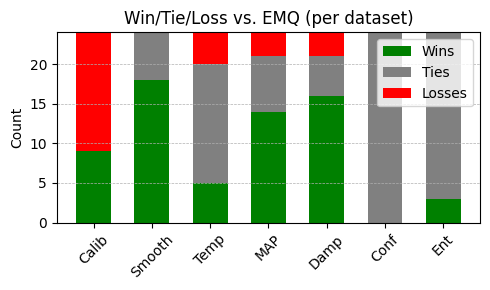

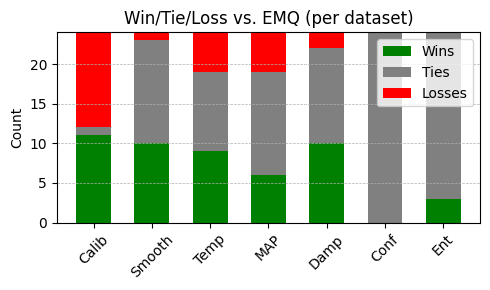

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_win_tie_loss(exp, csv_results_path, method_names, display_labels, baseline_method, tie_tolerance=1e-6):
    """
    Generate a stacked bar chart showing win/tie/loss counts per method vs. baseline (EMQ).

    Parameters:
        csv_results_path (str): Path to the CSV file.
        method_names (list): List of method IDs to evaluate (excluding baseline).
        display_labels (list): Labels to show on the x-axis.
        baseline_method (str): Method name used as the baseline for comparison.
        tie_tolerance (float): Allowed tolerance for ties.
    """
    assert len(method_names) == len(display_labels), "Method names and labels must match"

    # Load and pivot data
    df = pd.read_csv(csv_results_path, sep='\t')
    df = df[df['Method'].isin(method_names + [baseline_method])]
    pivot = df.pivot(index='Dataset', columns='Method', values='MAE')

    # Initialize counters
    wins, ties, losses = [], [], []

    for m in method_names:
        diff = pivot[baseline_method] - pivot[m]
        wins.append((diff > tie_tolerance).sum())
        ties.append((diff.abs() <= tie_tolerance).sum())
        losses.append((diff < -tie_tolerance).sum())

    # Create bar chart
    x = np.arange(len(display_labels))
    width = 0.6

    plt.figure(figsize=(5, 3))
    plt.bar(x, wins, width, label='Wins', color='green')
    plt.bar(x, ties, width, bottom=wins, label='Ties', color='gray')
    plt.bar(x, losses, width, bottom=np.array(wins)+np.array(ties), label='Losses', color='red')

    plt.xticks(x, display_labels, rotation=45)
    plt.ylabel("Count")
    plt.title("Win/Tie/Loss vs. EMQ (per dataset)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig("win_tie_loss_summary_{}.pdf".format(exp), format="pdf", bbox_inches="tight")
    plt.show()


methods = ['EM_LR','EM_BCTS_LR','PSEM_LR','TSEM_LR','DMAPEM_LR','DEM_LR','CSEM_LR','EREM_LR']
labels = ['EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent']
methods_no_emq = methods[1:]
labels_no_emq = labels[1:]

plot_win_tie_loss(
    'LR',
    'results/ucimulti/allmethods.csv',
    methods_no_emq,
    labels_no_emq,
    baseline_method=methods[0]  # e.g., 'EM_LR'
)

methods = ['EM_NN','EM_BCTS_NN','PSEM_NN','TSEM_NN','DMAPEM_NN','DEM_NN','CSEM_NN','EREM_NN']
labels = ['EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent']
methods_no_emq = methods[1:]
labels_no_emq = labels[1:]

plot_win_tie_loss(
    'NN',
    'results/ucimulti/allmethods.csv',
    methods_no_emq,
    labels_no_emq,
    baseline_method=methods[0]  # e.g., 'EM_LR'
)